
import numpy as np
import pandas
import matplotlib as plt

#print ("Hi all")
#weekMax = 51
#NShops = 80
#lastNWeeksDown = 6

def changeConfig(sWeek, sItem, sStore):

    configfilename = "params.txt"
    fconfig = open(configfilename, "r")
    linesList = []
    for l in fconfig:
        toNewConf  = l
        if l.split()[0] == 'sWeek':
            toNewConf = 'sWeek = ' + str(sWeek) + "\n"

        if l.split()[0] == 'sItem':
            toNewConf = 'sItem = ' + str(sItem) + "\n"

        if l.split()[0] == 'sStore':
            toNewConf = 'sStore = ' + str(sStore) + "\n"
        linesList.append(toNewConf)


    fconfig.close()
    fconfig = open(configfilename, "w")
    for line in linesList:
        fconfig.write(line)



def generateSimpleData(delta, alpha, scale, season):

    priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), (1 - delta)*np.ones((NShops,lastNWeeksDown)), 1)
    
    #lastMarkdownArray = (1 - delta/2)*np.ones((NShops,lastNWeeksDown/2))
    #lastMarkdownArray = np.append(lastMarkdownArray, (1 - delta)*np.ones((NShops,lastNWeeksDown/2)), 1)
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), lastMarkdownArray, 1)
    
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), np.random.uniform(1 - delta - 0.1,1 - delta + 0.1 ,(NShops,lastNWeeksDown)), 1)
    
    #effictivityScale = scale*np.arange(1, NShops+1)
    effictivityScale = scale*np.linspace(1, 10, NShops) 

    slsu = np.zeros((NShops, weekMax))
    for weekNo in range(weekMax):
        for ShopNo in range(NShops):
            slsu[ShopNo, weekNo] = np.random.poisson(effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha)))
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return priceMatrix,  slsu


def DataToFile(slsu, price, onHand):
    fLogP = open("RawData/RawDataLogPrice.txt", "w")
    fSlsu = open("RawData/RawDataSLSU.txt", "w")
    fBoh = open("RawData/RawDataBOH.txt", "w")
    
    for shopNo in range(NShops):
        for t in range(weekMax):
            #print np.log(price[shopNo, t]), " "
            fLogP.write(str( -np.log(price[shopNo, t])) + " ")
            fSlsu.write(str(slsu[shopNo, t])+ " ")
            fBoh.write(str(onHand[shopNo, t])+ " ")

if __name__ == "__main__":

    #season = np.cos (np.linspace(0, 2*np.pi, weekMax)) + 2
    #season = np.linspace(1, 0, weekMax) + 2
    season = np.array([1]*weekMax)
    season = season/sum(season)

    price, slsu = generateSimpleData(delta = 0.2, alpha = 1.75, scale = 400, season = season)
    onHand = np.ones((NShops,weekMax) )*100
    #print price, slsu, onHand
    #DataToFile(slsu, price, onHand)
    #changeConfig(sWeek =weekMax , sItem = 1, sStore = NShops)

dics = np.random.randint(0, 12)

price,  slsu, on_hand, rew = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)

res_ser = rew*unit_price
days_left = np.arange(weekMax, 0, -1)  






state_cols = ['d_r_sh', 'days_left']

df = pd.concat([pd.Series(price), 
           pd.Series(season),
           pd.Series(on_hand),
           pd.Series(days_left), 
           pd.Series(slsu), 
           pd.Series(res_ser)], 1)

df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser']
df['d_r_sh'] = df.on_hand / df.slsu


df['action'] = (df.price.shift(-1) - df.price ).fillna(0)

df_shifted = df[state_cols].shift(-1)
df_shifted.columns = [col + '_next' for col in df_shifted.columns]




pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser']]], 1)

In [1]:
%matplotlib inline

In [2]:
def generateSimpleData(delta, alpha, scale, season, init_oh, disc_len, weekMax):

    price = np.append(np.ones( weekMax - disc_len), (1 - delta)*np.ones(disc_len))
    
    slsu = np.zeros(weekMax)
    bst_est = np.zeros(weekMax)
    on_hand = np.zeros(weekMax)
    on_hand[0]=init_oh
    rew = np.zeros(weekMax)
    
    for weekNo in range(weekMax):
        if weekNo:
            on_hand[weekNo] = on_hand[weekNo-1] - slsu[weekNo-1]   
            
        curr_mean =scale*weekMax*season[weekNo]*(price[ weekNo]**(-alpha))
        demand = np.random.poisson(curr_mean)
        slsu[weekNo] = min(demand, on_hand[weekNo])
        rew[weekNo] = slsu[weekNo]*price[weekNo]
        bst_est[weekNo] = curr_mean
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return price,  slsu, on_hand, rew, bst_est

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd

In [4]:
weekMax = 12
init_oh = 800

season = np.array([1]*weekMax)
season = season/sum(season)

In [5]:
res_dict = {}
for dics in tqdm(np.linspace(.0,.7, 40 )):
    tmp_list = []
    for i in range(1000):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = dics, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = 6, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)


100%|██████████| 40/40 [00:09<00:00,  4.75it/s]


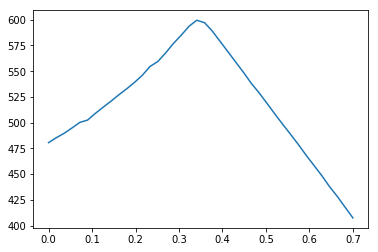

In [6]:
pd.Series(res_dict).plot()

In [7]:
res_dict = {}
for dics in tqdm(range(12)):
    tmp_list = []
    for i in range(100):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)

100%|██████████| 12/12 [00:00<00:00, 30.71it/s]


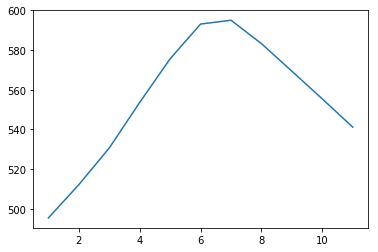

In [8]:
pd.Series(res_dict).rolling(2).mean().plot()

In [9]:
state_cols = ['days_left', 'oh_after']
next_state_cols = [col + '_next' for col in state_cols]

def gen_rl_df(delta, alpha, scale, season, init_oh, disc_len, unit_price =1, weekMax = 12):
    dics = np.random.randint(0, weekMax)
    price,  slsu, on_hand, rew, best_est = generateSimpleData(delta, alpha, scale, \
                                                    season, init_oh, disc_len = dics, weekMax = weekMax)

    res_ser = rew*unit_price
    days_left = np.arange(weekMax, 0, -1)-1


    df = pd.concat([pd.Series(price), 
               pd.Series(season),
               pd.Series(on_hand),
               pd.Series(days_left), 
               pd.Series(slsu), 
               pd.Series(res_ser).shift(-1), 
               pd.Series(best_est)], 1)

    
    df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser', 'bst_est']
    df['d_r_sh'] = df.on_hand / df.slsu
    df['oh_after'] = df.on_hand - df.slsu


    df['action'] = (df.price -1. ).fillna(0)

    df_shifted = df[state_cols].shift(-1)
    df_shifted.columns = next_state_cols

    return pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser', 'slsu', 'bst_est']]], 1)
    


def V(oh_left, reg_sales,disc_sales,delta, days_left  ):
    res_list = [1*min(reg_sales*days_left,oh_left)]
    
    for i in range(days_left):
        reg_price_sales = min(i*reg_sales, oh_left)
        cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
        res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

    return max(res_list)

def Q(oh_left, reg_sales,disc_sales,delta, days_left, action):
    if not days_left:
        return 0
    
    if action >= 0:
        res_list = [1*min(reg_sales*days_left,oh_left)]
        
        for i in range(1, days_left+1):
            reg_price_sales = min(i*reg_sales, oh_left)
            cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
            res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

        return  max(res_list)
    
    return (1- delta)*min(disc_sales*days_left,oh_left)


### Train exact

In [10]:

samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

100%|██████████| 1000/1000 [00:18<00:00, 54.75it/s]
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [189]:
from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [180]:

samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
df['oh_after'] = df.on_hand - df.slsu
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)
df['predicted'] = r.predict(df[['oh_after', 'days_left']].values)

100%|██████████| 100/100 [00:01<00:00, 71.00it/s]
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

# Q-learning training

In [12]:
from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
#r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

In [13]:
df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

In [292]:
for i in tqdm(range(60)):
    if i:
        
        df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
        df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])
        
        df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.
        
        df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
        df['target']   = df.rev_ser + df['V_next']
    else:
        df['target'] = df.rev_ser
        
    r.fit(df[[ 'days_left','oh_after', 'action']].values, df.target.values)






  0%|          | 0/60 [00:00<?, ?it/s]




  2%|▏         | 1/60 [00:13<13:18, 13.53s/it]




  3%|▎         | 2/60 [00:29<13:45, 14.23s/it]




  5%|▌         | 3/60 [00:47<14:29, 15.26s/it]




  7%|▋         | 4/60 [01:02<14:19, 15.34s/it]




  8%|▊         | 5/60 [01:19<14:30, 15.83s/it]




 10%|█         | 6/60 [01:39<15:16, 16.98s/it]




 12%|█▏        | 7/60 [01:55<14:45, 16.71s/it]




 13%|█▎        | 8/60 [02:07<13:24, 15.48s/it]




 15%|█▌        | 9/60 [02:21<12:38, 14.87s/it]




 17%|█▋        | 10/60 [02:35<12:08, 14.57s/it]




 18%|█▊        | 11/60 [02:50<12:07, 14.85s/it]




 20%|██        | 12/60 [03:05<11:46, 14.72s/it]




 22%|██▏       | 13/60 [03:18<11:08, 14.22s/it]




 23%|██▎       | 14/60 [03:30<10:23, 13.55s/it]




 25%|██▌       | 15/60 [03:45<10:35, 14.12s/it]




 27%|██▋       | 16/60 [03:59<10:19, 14.07s/it]




 28%|██▊       | 17/60 [04:13<10:08, 14.14s/it]




 30%|███       | 18/60 [04:28<10:01, 14.32s/it]




 32%|███▏      | 19/60 [0

i = 0

print(i)
if i:
        
    df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
    df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])

    df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.

    df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
    df['target']   = df.rev_ser + df['V_next']
else:
    df['target'] = df.rev_ser

r.fit(df[[ 'days_left', 'oh_after','action']].values, df.target.values)
i+=1

In [15]:
!pwd

/Volumes/C/demt_msu_exp/rl_experiments


In [294]:

df

,days_left,oh_after,days_left_next,oh_after_next,action,rev_ser,dumm_0,dumm_m35,V,Q_keep,Q_disc,target,pred_0,pred_m35,V_next
0,11,762.0,10.0,714.0,0.00,48.00,0.0,-0.35,565.3000,565.3000,495.300,547.105757,499.105757,499.105757,499.105757
1,10,714.0,9.0,614.0,0.00,65.00,0.0,-0.35,520.1000,520.1000,464.100,492.137445,427.137445,398.984664,427.137445
2,9,614.0,8.0,529.0,-0.35,55.25,0.0,-0.35,455.1000,455.1000,399.100,399.049913,343.799913,343.799913,343.799913
3,8,529.0,7.0,418.0,-0.35,72.15,0.0,-0.35,399.8500,399.8500,343.850,343.844391,271.694391,271.694391,271.694391
4,7,418.0,6.0,326.0,-0.35,59.80,0.0,-0.35,327.7000,327.7000,271.700,271.712648,211.912648,211.912648,211.912648
5,6,326.0,5.0,243.0,-0.35,53.95,0.0,-0.35,267.9000,267.9000,211.900,211.866846,157.916846,157.916846,157.916846
6,5,243.0,4.0,142.0,-0.35,65.65,0.0,-0.35,213.9500,213.9500,157.950,157.902179,92.252179,92.252179,92.252179
7,4,142.0,3.0,57.0,-0.35,55.25,0.0,-0.35,142.0000,142.0000,92.300,92.301300,37.051300,37.051300,37.051300
8,3,57.0,2.0,0.0,-0.35,37.05,0.0,-0.35,57.0000,57.0000,37.050,37.050000,0.000000,0.000000,0.000000
9,2,0.0,1.0,0.0,-0.35,0.00,0.0,-0.35,0.0000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000


In [295]:
samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)







  0%|          | 0/100 [00:00<?, ?it/s]




  4%|▍         | 4/100 [00:00<00:02, 36.91it/s]




  8%|▊         | 8/100 [00:00<00:02, 37.09it/s]




 13%|█▎        | 13/100 [00:00<00:02, 39.80it/s]




 16%|█▌        | 16/100 [00:00<00:02, 35.45it/s]




 20%|██        | 20/100 [00:00<00:02, 35.55it/s]




 27%|██▋       | 27/100 [00:00<00:01, 41.60it/s]




 34%|███▍      | 34/100 [00:00<00:01, 47.09it/s]




 39%|███▉      | 39/100 [00:01<00:01, 31.92it/s]




 44%|████▍     | 44/100 [00:01<00:01, 31.91it/s]




 48%|████▊     | 48/100 [00:01<00:01, 33.47it/s]




 53%|█████▎    | 53/100 [00:01<00:01, 36.82it/s]




 58%|█████▊    | 58/100 [00:01<00:01, 39.49it/s]




 63%|██████▎   | 63/100 [00:01<00:01, 31.08it/s]




 68%|██████▊   | 68/100 [00:01<00:00, 34.82it/s]




 73%|███████▎  | 73/100 [00:01<00:00, 37.61it/s]




 80%|████████  | 80/100 [00:02<00:00, 42.94it/s]




 85%|████████▌ | 85/100 [00:02<00:00, 36.29it/s]




 90%|█████████ | 90/100 [00:02<00:00, 34.34it/s]





In [299]:
df['dumm_0'] = 0.
df['dumm_m35'] = -.35
df['Q_keep_pred'] = r.predict(df[['days_left','oh_after', 'dumm_0']].values)
df['Q_disc_pred'] = r.predict(df[['days_left','oh_after', 'dumm_m35']].values)

In [303]:
df[['days_left', 'on_hand', 'price','rev_ser' ,'Q_keep', 'Q_disc', 'Q_keep_pred', 'Q_disc_pred']]

,days_left,on_hand,price,rev_ser,Q_keep,Q_disc,Q_keep_pred,Q_disc_pred
0,11,800.0,1.00,61.10,569.2130,500.5000,542.723348,542.723348
1,10,770.0,0.65,69.55,507.6775,439.4000,480.485108,454.961315
2,9,676.0,0.65,55.25,439.8500,369.8500,380.125751,369.662465
3,8,569.0,0.65,64.35,384.6000,314.6000,304.225409,314.282282
4,7,484.0,0.65,57.20,320.2500,250.2500,250.164760,250.164760
5,6,385.0,0.65,63.70,261.5355,193.0500,192.983844,192.983844
6,5,297.0,0.65,62.40,199.0000,129.3500,129.276922,129.276922
7,4,199.0,0.65,66.30,103.0000,66.9500,66.953527,66.953527
8,3,103.0,0.65,0.65,1.0000,0.6500,0.395200,0.395200
9,2,1.0,0.65,0.00,0.0000,0.0000,0.000000,0.000000


In [197]:
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

,days_left,oh_after,days_left_next,oh_after_next,action,rev_ser
0,11,747.0,10.0,699.0,0.00,53.00
1,10,699.0,9.0,660.0,0.00,48.00
2,9,660.0,8.0,573.0,-0.35,39.00
3,8,573.0,7.0,490.0,0.00,56.55
4,7,490.0,6.0,380.0,0.00,53.95
5,6,380.0,5.0,289.0,0.00,71.50
6,5,289.0,4.0,203.0,0.00,59.15
7,4,203.0,3.0,99.0,0.00,55.90
8,3,99.0,2.0,1.0,0.00,67.60
9,2,1.0,1.0,0.0,0.00,63.70
